# Introduction

This project is based on the Kaggle copetition “I’m Something of a Painter Myself,” The task is to generate 7,000 to 10,000 images in the style of Monet. Given the nature of this competition, CycleGAN is recommended as an effective model mainly because, unlike traditional GANs that require paired datasets, it can learn from unpaired data, making it suitable for tasks where such data is not available.

I refer to the 4 notebooks shared by ShravanKumar for the basic steps to explore the dataset and to build the model: \
https://www.kaggle.com/code/shravankumar147/01-baseline-generating-monet-style-images
https://www.kaggle.com/code/shravankumar147/02-monetgen-data-exploration
https://www.kaggle.com/code/shravankumar147/03-monetgen-cyclegan-train-eval
https://www.kaggle.com/code/shravankumar147/04-monetgen-inference


This notebook mainly follows the contents below.
1. EDA of the dataset
2. Building and Training the model
3. Evaluation & Conclusion
4. (The process to reload the model and submit the outputs on Kaggle)

# Setting up the Environment

In [1]:
# Install Pytorch
!pip install torch torchvision matplotlib

In [1]:
import os
import time
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import defaultdict

# 1. Exploring the Dataset

In this task, we handle two datasets:

- **Monet Paintings**: A collection of images created by Claude Monet, representing the target style we aim to replicate.
- **Photos**: A set of regular photographs that we want to transform into the Monet painting style.

(The Monet paintings and photos do not have a direct correspondence, i.e., no paired data like a photo and its Monet-style counterpart).

#### Creating the Dataset Class

We’ll define a custom dataset class for loading images from both domains (Monet paintings and photos) and applying necessary transformations like resizing and normalization.

In [2]:
# Dataset class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Create datasets for Monet paintings and photos
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photos_path = "/kaggle/input/gan-getting-started/photo_jpg"

monet_dataset = ImageDataset(root_dir=monet_path, transform=transform)
photo_dataset = ImageDataset(root_dir=photos_path, transform=transform)

In [5]:
len(monet_dataset), len(photo_dataset)

(300, 7038)

#### Creating DataLoaders

Data loaders are used to handle batch loading, shuffling, and parallel data loading, which are important for efficient training.

**Importance of DataLoaders**:
- **Batching**: Processes multiple images in each iteration, speeding up training and helping with generalization.
- **Shuffling**: Ensures that the model doesn’t memorize the order of images, promoting better learning.
- **Parallel Loading**: Uses multiple CPU cores for data loading, reducing the time needed to load data and increasing training efficiency.

In [6]:
batch_size = 4

In [7]:
# Create data loaders
monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

#### Visualizing a Few Samples

Visualizing samples helps us understand the dataset and verify that our data preprocessing steps are working correctly.

In [8]:
# Function to show images
def show_images(images, title=None):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
    if title:
        fig.suptitle(title, fontsize=16)
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
        img = img * 0.5 + 0.5  # Denormalize
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [9]:
# Get some images
monet_iter = iter(monet_loader)
photo_iter = iter(photo_loader)

monet_images = [next(monet_iter) for _ in range(4)]
photo_images = [next(photo_iter) for _ in range(4)]

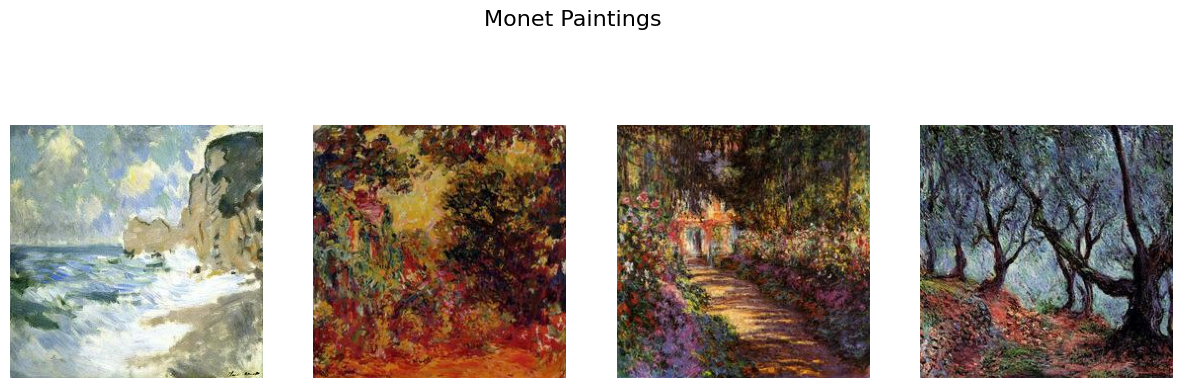

In [10]:
show_images([monet_images[i][0] for i in range(4)], title='Monet Paintings')

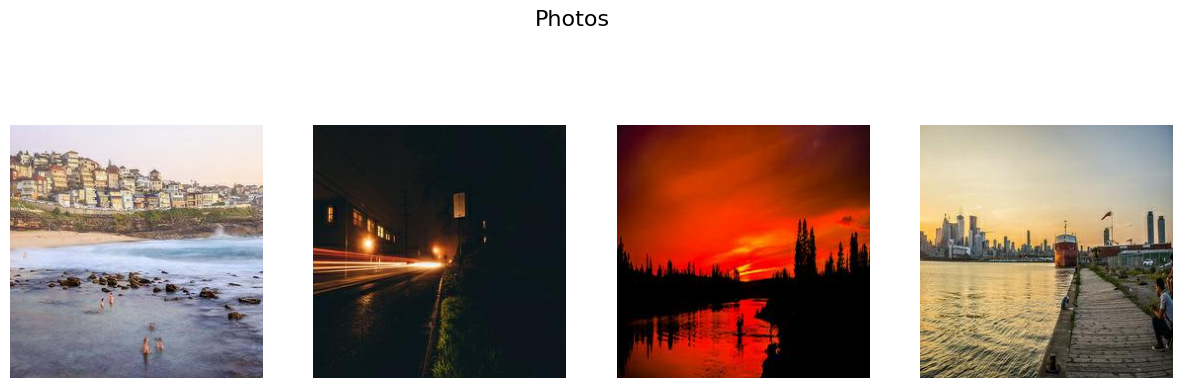

In [11]:
show_images([photo_images[i][0] for i in range(4)], title='Photos')

#### Explanation of Unpaired Images and CycleGAN

**Unpaired Images**:
- In many real-world scenarios, we don’t have direct pairs of images from two different domains. For example, we don’t have a direct photograph and its corresponding Monet-style painting.
- Unpaired datasets consist of two separate sets of images (e.g., Monet paintings and photos) without direct correspondences between them.

**Importance of CycleGAN**:
- **Bidirectional Mapping**: CycleGAN maps images from the domain of photos to the domain of Monet paintings and vice versa. This ensures the generated images look realistic and retain the structural integrity of the original photos.
- **Cycle Consistency**: The cycle consistency loss in CycleGAN ensures that an image can be translated to another domain and back to its original form, preserving essential content and structure.
- **Style Transfer**: CycleGAN is designed to learn the artistic style of one set of images (Monet paintings) and apply it to another set (photos), making it ideal for tasks like creating Monet-style images from regular photos.

# 2. Building a CycleGAN model

We build and train a CycleGAN to translate photos into Monet-style paintings using PyTorch. We’ll cover the following steps:

1. **Build a Simple Baseline CycleGAN Architecture**: We’ll implement the generator and discriminator models and explain our choices.
2. **Train and Evaluate the Model**: We’ll train the CycleGAN on the Monet and photo datasets, providing explanations for the training process and evaluation.

#### Baseline CycleGAN Architecture

CycleGAN consists of two main components:
- **Generators**: Two generators \( G \) and \( F \) for mapping between the two domains (photos to Monet and Monet to photos).
- **Discriminators**: Two discriminators \( D_X \) and \( D_Y \) to differentiate between real and generated images in both domains.

#### *Generator*

The generator is typically an encoder-decoder network with residual blocks for learning complex mappings between domains. The architecture we'll use is inspired by U-Net.

- **Residual Blocks**: They help in capturing fine details and textures, which is crucial for style transfer.
- **U-Net Structure**: This helps preserve the content of the input image while applying style changes.

#### *Discriminator*

The discriminator is a convolutional network that outputs whether an input image is real or generated.

- **PatchGAN Discriminator**: Instead of a binary output, it produces a patch-level prediction, which helps focus on high-frequency details.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(6)]
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

In [13]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

### Train and Evaluate the Model

We’ll define the training loop with the following components:
- **Cycle Consistency Loss**: Ensures that translating to another domain and back preserves the original image.
- **Adversarial Loss**: Encourages the generator to produce realistic images.
- **Identity Loss**: Helps the generator maintain the color and structure of the input image when no transformation is needed.

In [14]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
G_XtoY = Generator(in_channels=3, out_channels=3).to(device)
G_YtoX = Generator(in_channels=3, out_channels=3).to(device)
D_X = Discriminator(in_channels=3).to(device)
D_Y = Discriminator(in_channels=3).to(device)

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [15]:
# Training loop
num_epochs = 10
losses_dict = defaultdict(list)
# Get the start time
start_time = time.process_time()
for epoch in range(num_epochs):
    start_time_epoch = time.process_time()
    for i, (real_X, real_Y) in enumerate(zip(photo_loader, monet_loader)):
        real_X, real_Y = real_X.to(device), real_Y.to(device)

        # Train Generators
        optimizer_G.zero_grad()

        # GAN loss
        fake_Y = G_XtoY(real_X)
        pred_fake = D_Y(fake_Y)
        loss_GAN_XtoY = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_X = G_YtoX(real_Y)
        pred_fake = D_X(fake_X)
        loss_GAN_YtoX = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        # Cycle loss
        recovered_X = G_YtoX(fake_Y)
        loss_cycle_X = criterion_cycle(recovered_X, real_X)

        recovered_Y = G_XtoY(fake_X)
        loss_cycle_Y = criterion_cycle(recovered_Y, real_Y)

        # Identity loss
        loss_identity_X = criterion_identity(G_YtoX(real_X), real_X)
        loss_identity_Y = criterion_identity(G_XtoY(real_Y), real_Y)

        # Total loss
        loss_G = loss_GAN_XtoY + loss_GAN_YtoX + 10.0 * (loss_cycle_X + loss_cycle_Y) + 5.0 * (loss_identity_X + loss_identity_Y)
        loss_G.backward()
        optimizer_G.step()
        

        # Train Discriminators
        optimizer_D_X.zero_grad()

        pred_real = D_X(real_X)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        pred_fake = D_X(fake_X.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D_X = (loss_D_real + loss_D_fake) * 0.5
        loss_D_X.backward()
        optimizer_D_X.step()

        optimizer_D_Y.zero_grad()

        pred_real = D_Y(real_Y)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        pred_fake = D_Y(fake_Y.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D_Y = (loss_D_real + loss_D_fake) * 0.5
        loss_D_Y.backward()
        optimizer_D_Y.step()
        
        losses_dict['loss_G'].append(loss_G.item())
        losses_dict['loss_D_X'].append(loss_D_X.item())
        losses_dict['loss_D_Y'].append(loss_D_Y.item())
        
        if i%50==0:
            print(f'Epoch [{epoch+1}/{num_epochs}], batch_idx : {i}, Loss G: {loss_G.item()}, Loss D_X: {loss_D_X.item()}, Loss D_Y: {loss_D_Y.item()}')
    
    # Get the end time
    end_time_epoch = time.process_time()
    # Compute the execution time
    epoch_execution_time = end_time_epoch - start_time_epoch
    print(f'CPU Execution time/Epoch: {epoch_execution_time} seconds')
    
    print(f"Completed Epoch: {epoch+1}")
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_G.item()}, Loss D_X: {loss_D_X.item()}, Loss D_Y: {loss_D_Y.item()}')
    print(80*'=')
    
# Get the end time
end_time = time.process_time()

# Compute the execution time
execution_time = end_time - start_time
print(f'CPU Total Execution time: {execution_time} seconds')    

Epoch [1/10], batch_idx : 0, Loss G: 16.79359245300293, Loss D_X: 0.4654426872730255, Loss D_Y: 0.5728886127471924
Epoch [1/10], batch_idx : 50, Loss G: 6.8486433029174805, Loss D_X: 0.2855002284049988, Loss D_Y: 0.23663631081581116
CPU Execution time/Epoch: 65.829272438 seconds
Completed Epoch: 1
Epoch [1/10], Loss G: 7.139743804931641, Loss D_X: 0.26610255241394043, Loss D_Y: 0.25044018030166626
Epoch [2/10], batch_idx : 0, Loss G: 6.268179893493652, Loss D_X: 0.23286041617393494, Loss D_Y: 0.24133217334747314
Epoch [2/10], batch_idx : 50, Loss G: 6.244062423706055, Loss D_X: 0.29792320728302, Loss D_Y: 0.2182081639766693
CPU Execution time/Epoch: 65.525766041 seconds
Completed Epoch: 2
Epoch [2/10], Loss G: 7.071639537811279, Loss D_X: 0.18310564756393433, Loss D_Y: 0.17274674773216248
Epoch [3/10], batch_idx : 0, Loss G: 5.424594879150391, Loss D_X: 0.1806849241256714, Loss D_Y: 0.2199275940656662
Epoch [3/10], batch_idx : 50, Loss G: 6.114310264587402, Loss D_X: 0.2414697259664535

In [16]:
# Save the model
# torch.save(G_XtoY.state_dict(), 'G_XtoY.pth')

# 3. Evaluation

For evaluation, we’ll generate some Monet-style images from the photos and visually inspect the results.

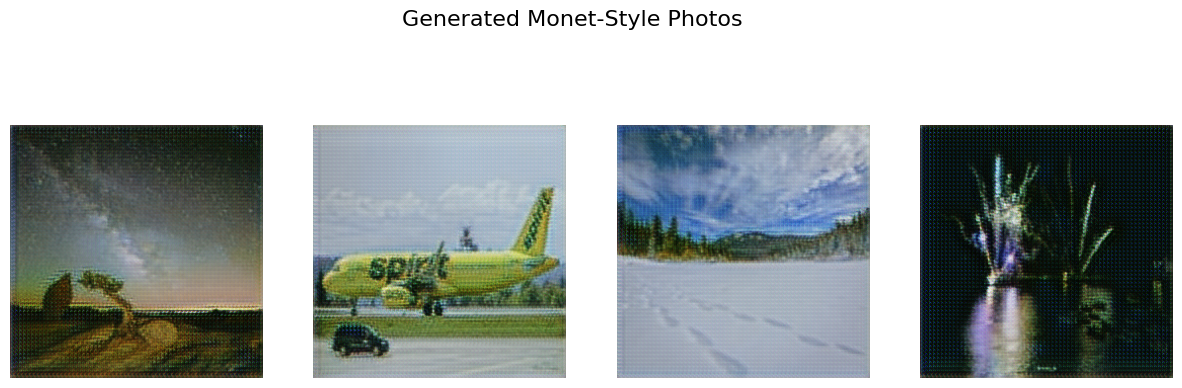

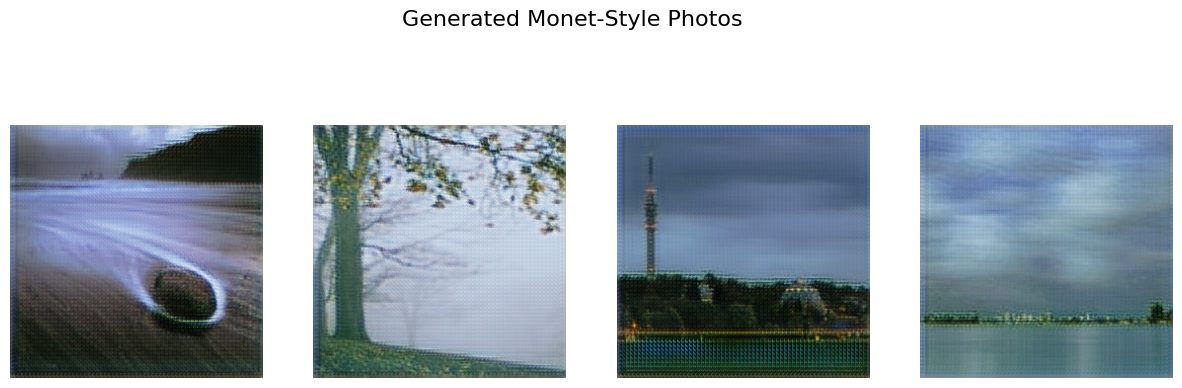

In [17]:
# Function to generate and show results
def generate_and_show_images(generator, loader, num_images=4):
    generator.eval()
    with torch.no_grad():
        for i, images in enumerate(loader):
            images = images.to(device)
            generated_images = generator(images)
            show_images([generated_images[j].cpu() for j in range(num_images)], title='Generated Monet-Style Photos')
            if i >= num_images // 4:
                break

generate_and_show_images(G_XtoY, photo_loader)

## Conclusion

By following these steps, we’ve built and trained a CycleGAN using PyTorch to translate photos into Monet-style paintings. This approach leverages the power of unpaired image-to-image translation, making it suitable for tasks where paired datasets are unavailable. The use of CycleGAN ensures that the generated images not only adopt the desired style but also retain the original content and structure of the input images.

# 4. Submission (Loading the model after training & Making a zip file)

The steps below are the code to reload the model, which was saved earlier, creating the required format of outputs, and submit for the competition.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import shutil

# Define the Generator model class
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(6)]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# Residual Block class
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

*You have to upload the trained model data to your environment.*

In [4]:
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_XtoY = Generator(in_channels=3, out_channels=3).to(device)
G_XtoY.load_state_dict(torch.load('/kaggle/input/monetgen_practice/pytorch/default/1/G_XtoY.pth'))
G_XtoY.eval()

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [5]:
# Process the photos
import os
from torchvision import transforms
from PIL import Image
import numpy as np

# Path to the directory containing photos
photos_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load and preprocess photos
photo_filenames = [f for f in os.listdir(photos_path) if f.endswith('.jpg')]
photos = []
for filename in photo_filenames:
    image = Image.open(os.path.join(photos_path, filename)).convert('RGB')
    image = transform(image)
    photos.append(image)

photos = torch.stack(photos)

In [6]:
photos[:5].shape

torch.Size([5, 3, 256, 256])

In [9]:
%%time
# Generate images by the model
# Directory to save the output images
output_dir = '/images'
os.makedirs(output_dir, exist_ok=True)

# Generate Monet-style images
with torch.no_grad():
    for i, photo in enumerate(photos):
        photo = photo.unsqueeze(0).to(device)  # Add batch dimension
        monet_style_image = G_XtoY(photo)
        monet_style_image = monet_style_image.squeeze(0).cpu()  # Remove batch dimension

        # Convert tensor to PIL Image and denormalize
        monet_style_image = transforms.ToPILImage()(monet_style_image * 0.5 + 0.5)
        monet_style_image.save(os.path.join(output_dir, f'monet_style_{i+1}.jpg'))


CPU times: user 2min 50s, sys: 716 ms, total: 2min 51s
Wall time: 1min 26s


In [10]:
# Make Zipfile
import shutil

shutil.make_archive("/kaggle/working/images", 'zip', output_dir)

'/kaggle/working/images.zip'

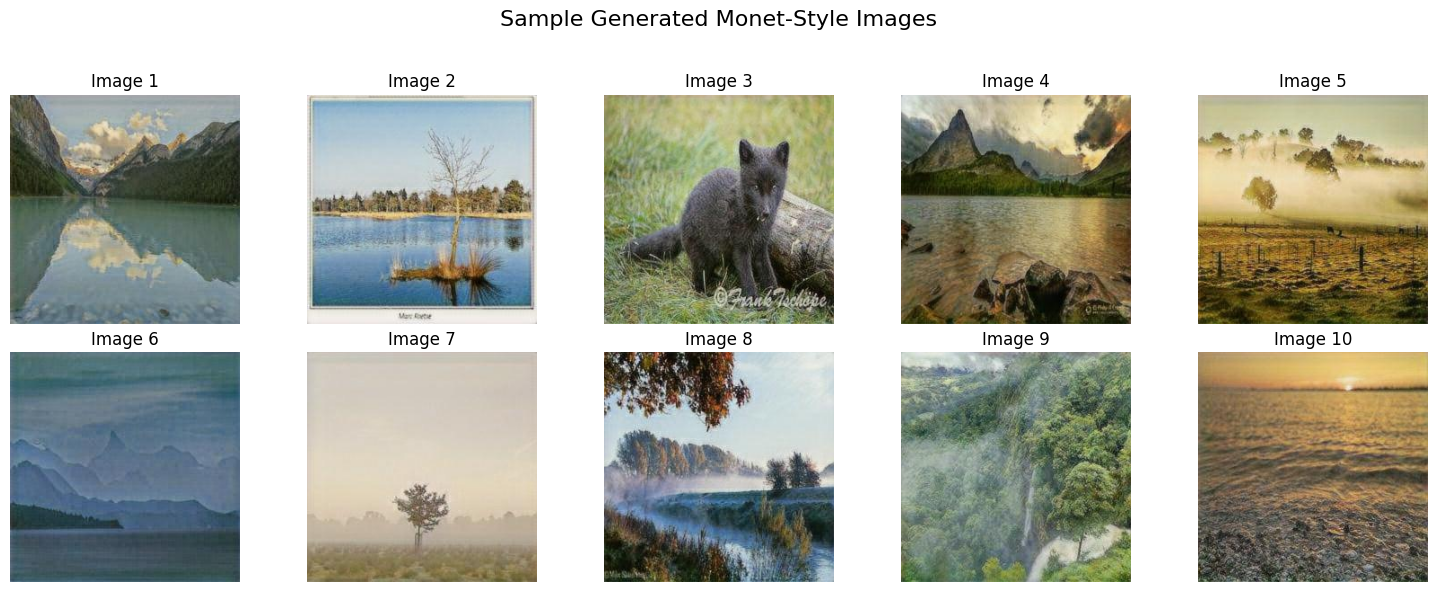

In [11]:
# See some outputs
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Number of images to display
num_images = 10

# Get list of image file names
image_files = [f for f in os.listdir(output_dir) if f.endswith('.jpg')]

# Randomly select images to display
sample_images = random.sample(image_files, num_images)

# Set up Matplotlib figure
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Generated Monet-Style Images', fontsize=16)

# Plot images
for i, ax in enumerate(axs.flatten()):
    img_path = os.path.join(output_dir, sample_images[i])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Turn off axis
    ax.set_title(f"Image {i+1}")

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

You can submit the output by pressing the "Submit" button in the Kaggle coding page.